In [1]:
import qiskit
qiskit.__version__

'0.16.1'

$$
\delta \theta 1 = 0.08\pi \\
\delta \theta 2 = 0.001\pi 
$$

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import qrng
import pandas as pd
import seaborn as sns
from math import pi

# importing Qiskit
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_city
from qiskit_textbook.tools import array_to_latex

# Import time module
import time

In [3]:
#Initialize HyperParameter
MaxNsol = 300 #define MaxNsol
MaxNvar = 150 #define MaxNvar

# Nrun = 10     #define Nrun
Ngen = 30   #define Ngen  
Nsol = 5     #define Nsol
Nvar = 10     #define Nvar
Nbit = 10      #define the variable bits
Qbest_sol = Nsol + 1 # solution Number include Qbest_sol 
Qbest_idx = Nsol # Index of Qbest_sol 
theta_1 = 0.08 *pi
theta_2 = 0.001 *pi

Cg = 0.7 #define Cg
Cp = 0.9 #define Cp  
# Cw = 0.9 #define Cw

apitoken ='e26cab383f69b81aaf36106b0620f3e994afd5ef57bb861bc714b41a91dabb3c08dcc5f5f45fa395a490d1bbf0490a8b1e7caeeaa560546833ca8149d4375ef3'

In [4]:
# Create QuantumCircuit List = sol_list
# return a qc_list represent the solution value [x1, x2, x3, ...]
def Qsol_init():
    qc_list = []
    for var in range(Nvar):
        qc = QuantumCircuit(Nbit, Nbit) # Circuit with Nbit qubits and Nbit classical bits
        qr = QuantumRegister(Nbit, 'q')
        cr = ClassicalRegister(Nbit, 'c')
        qc = QuantumCircuit(qr, cr)
        qc.h(qr[0:Nbit])
        qc_list.append(qc)
    return qc_list # return a solution with Nvar

In [5]:
# Initialize one generation with Nsol
def God_init():
    '''
    Initialize one generation with Nsol + 1.
    Last one qc_list is Qgbest.
    '''
    God_list = []
    for sol in range(Qbest_sol):
        God_list.append(Qsol_init())
    return God_list
# God_list = God_init()

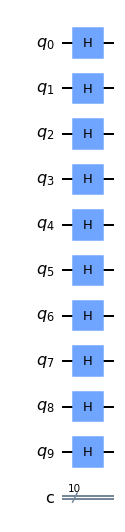

In [6]:
# Qgen_list[sol_i][var_i]
God_list = God_init()
God_list[0][0].draw('mpl')

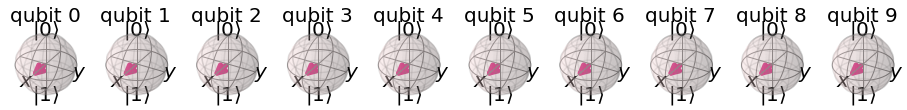

In [7]:
# Take a look at value of No.__variable in No.__sol by statevector_simulator
sol_idx = 2
var_idx = 3

backend = Aer.get_backend('statevector_simulator') 
out_state = execute(God_list[sol_idx][var_idx],backend).result().get_statevector() 
plot_bloch_multivector(out_state)

In [8]:
# 經過以上的看看態向量！
# array_to_latex(out_state, pretext="\\text{Statevector} = ")

In [9]:
# sol_measure function：Measure a Q state solution to classical bits
def sol_measure(Qsol_list):
    # Use simulator to measure one solution
    Csol_list = []
    Qstate_list = []
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend

    for qc in Qsol_list:
        qc_copy = qc
        for bit in range(Nbit):
            qc_copy.measure(bit, bit)
        result = execute(qc_copy, simulator).result() # defaul shot number
        result_dict = result.to_dict()
        Qstate_list.append(result_dict['results'][0]['data']['counts'])
    for var in Qstate_list:
        Keymax = max(var, key=var.get) 
        Csol_list.append(int(Keymax, 16))
    return Csol_list

# init_sol_list = sol_measure(God_list[0])
# init_sol_list

In [10]:
def var_measure(qc):
    '''
    var_measure function：Measure a Q state var to classical bits    
    '''
    # Use simulator to measure one solution
    simulator = Aer.get_backend('qasm_simulator') # qasm_simulator is a kind of Backend
    qc_copy = qc.copy()
    for bit in range(Nbit):
        qc_copy.measure(bit, bit)
    result = execute(qc_copy, simulator).result() # defaul shot number
    result_dict = result.to_dict()
    # print(result_dict)
    var_dict = result_dict['results'][0]['data']['counts']
    Keymax = max(var_dict, key=var_dict.get) 
    return int(Keymax, 16)

$$
Min \ Z = x_1^2 + x_2^2 + x_3^2 + ... + x_n^2
$$

In [11]:
def FIT_cal(XX):
    '''
    This function define the OBJ function and return the fitness value.
    In this example we use the square sum of each variable.
    '''
    SUM = 0
    for var in range(Nvar):
        SUM += XX[var] * XX[var]
    return SUM

In [12]:
def best_dict_init():
    '''
    Use best_dict to storage the gbest_fitness, gbest_list, pbest_fitness, pbest_list
    '''
    best_dict = {
        "gbest_fitness": 0,
        "gbest_sol": [0 for i in range(Nvar)],
        "pbest_fitness":[0 for i in range(Nsol)],
        "pbest_list":[[0 for i in range(Nvar)] for j in range(Nsol)]
    }
    return best_dict
best_dict = best_dict_init()

### Rotation around Y-axis
#### Main update operation of Quantum Genetic Algorithm

$$
R_y(\theta) =
\begin{pmatrix}
\cos(\theta/2) & - \sin(\theta/2)\\
\sin(\theta/2) & \cos(\theta/2).
\end{pmatrix} =u3(\theta,0,0)
$$

In [13]:
def int_to_bin(var):
    '''
    Def a function to convert int to binary_string.
    '''
    return format(var, f'0{Nbit}b')
# int_to_bin(12)

In [14]:
def get_Qrnd():
    '''
    Function to get random number from a Qubit in Quantum Computer.
    '''
    # IBMQ.save_account(apitoken)
    # provider = IBMQ.load_account()
    # qrng.set_provider_as_IBMQ(apitoken) #the IBMQ API token from your dashboard
    qrng.set_backend() #connect to the k qubit by quantum computer
    rnd = qrng.get_random_float(0,1) #generate a random N bit float between 0 to 1
    return rnd
# rnd = get_Qrnd()
# rnd

In [15]:
def sol_update(sol):
    '''
    Get a solution with Nvar from Qsol_list.
    '''
    Random_Qlist = Qsol_init()
    sol_list = []
    for var in range(Nvar):
        rnd = get_Qrnd()
        if (rnd<Cg):
            variable = (var_measure(God_list[Qbest_idx][var]))
            sol_list.append(variable)
        elif (rnd<Cp):
            variable = (var_measure(God_list[sol][var]))
            sol_list.append(variable)
        else:
            variable = (var_measure(Random_Qlist[var]))
            sol_list.append(variable)
    return sol_list


In [16]:
def get_bin_sol(sol_list):
    bin_list = []
    for var in sol_list:
        bin_list.append(int_to_bin(var))
    return bin_list

In [17]:
def get_ab_list(Qsol):
    '''
    This function will return a list with ai bi state in Qsol_list
    '''
    backend = Aer.get_backend('statevector_simulator') 
    ab_list = []
    for var in range(Nvar):
        ab_var = []
        for bit in range(Nbit):
            qc_tmp = Qsol[var].copy()
            # 從variable 的最右方的bit 開始量測
            collapse_bit = [i for i in range(Nbit) if i != bit]
            qc_tmp.measure(collapse_bit, collapse_bit)
            out_state = execute(qc_tmp,backend).result().get_statevector()
            # ab_bit = out_state[out_state>0].tolist()
            out_state_complex = out_state.tolist()
            out_state_real = [out_state_complex[i].real for i in range(len(out_state_complex))]
            ab_bit = [state for state in out_state_real if state != float(0)]
            # print(ab_bit) # if need to check the amplitude

            # if there is a the extreme condition! 
            if len(ab_bit) < 2:
                print("\n +-1 in the state_list!!")
                for i in range(len(out_state_real)):
                    if (out_state_real[i] != float(0)):
                        if ((int(int_to_bin(i)[Nbit - 1 - bit]) == 1)):
                            ab_bit = [0, 1]
                        elif (int(int_to_bin(i)[Nbit - 1 - bit]) == 0):
                            ab_bit = [1, 0]
            ab_var.append(ab_bit)
        ab_list.append(ab_var)
    return ab_list
# get_ab_list(God_list)


In [18]:
def God_update(sol, sol_list, sol_fitness):
    '''
    This function update the gbest and pbest for "SOLUTION_i" recorded in best_dict.
    '''
    global best_dict
    global God_list

    Qgbest_ab = get_ab_list(God_list[Qbest_idx])
    print(Qgbest_ab)
    
    curr_bin_sol = get_bin_sol(sol_list)
    # if curr_sol is better(in this case: smaller)

    if sol_fitness >= best_dict["gbest_fitness"]:
        # get the ai, bi of God_list[Qbest_idx]
        Qgbest_ab = get_ab_list(God_list[Qbest_idx])
        # print(f'Get better Gbest: {sol_fitness}!\n')

        # get the binary sol_list to compare
        gbest_bin_sol = get_bin_sol(best_dict["gbest_sol"])

        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qgbest_ab[var][Nbit - 1 - bit][0]
                b = Qgbest_ab[var][Nbit - 1 - bit][1]

                if (int(gbest_bin_sol[var][bit]) == 0 and int(curr_bin_sol[var][bit]) == 0):
                    # Let delta_theta = 0.001 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[Qbest_idx][var].ry((-2)*delta_theta, Nbit - 1 - bit)

                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.001 * pi
                    delta_theta = theta_2
                    if (a*b) > 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b) < 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(gbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.001 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.001 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
        # update the best_dict[gbest]
        best_dict["gbest_fitness"] = sol_fitness
        best_dict["gbest_sol"] = sol_list
    
    # if sol_fitness worse than best_dict["gbest_fitness"]
    elif sol_fitness < best_dict["gbest_fitness"]:
        # get the ai, bi of God_list[Qbest_idx]
        Qgbest_ab = get_ab_list(God_list[Qbest_idx])

        # get the binary sol_list to compare
        gbest_bin_sol = get_bin_sol(best_dict["gbest_sol"])
        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qgbest_ab[var][Nbit - 1 - bit][0]
                b = Qgbest_ab[var][Nbit - 1 - bit][1]
                if (int(gbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.001 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)

                if int(gbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.08 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(gbest_bin_sol[var][bit]) == 0 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(gbest_bin_sol[var][bit]) == 1 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[Qbest_idx][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[Qbest_idx][var].ry(2*delta_theta, Nbit - 1 - bit)
    # Compare for pbest_solution
    if sol_fitness >= best_dict["pbest_fitness"][sol]:
        # print(f'Get Better pbest sol_{sol}: {sol_fitness}')
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        pbest_bin_sol = get_bin_sol(best_dict["pbest_list"][sol])

        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取                
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if int(pbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(pbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(pbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(pbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 1)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

        best_dict["pbest_fitness"][sol] = sol_fitness
        best_dict["pbest_list"][sol] = sol_list
    
    elif sol_fitness < best_dict["pbest_fitness"][sol]:
        # get the ai, bi of God_list[Qsol]
        Qpbest_ab = get_ab_list(God_list[sol])
        # get the binary sol_list to compare
        pbest_bin_sol = get_bin_sol(best_dict["pbest_list"][sol])
        for var in range(Nvar):
            for bit in range(Nbit):
                # a, b要從尾巴取
                a = Qpbest_ab[var][Nbit - 1 - bit][0]
                b = Qpbest_ab[var][Nbit - 1 - bit][1]
                if (int(pbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit] == 0)):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a == 0 or b == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if int(pbest_bin_sol[var][bit] == 1) and int(curr_bin_sol[var][bit] == 0):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    
                if (int(pbest_bin_sol[var][bit] == 0) and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_1
                    if (a*b).real > 0:
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif (a*b).real < 0:
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif (a.real == 0 or b.real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)

                if (int(pbest_bin_sol[var][bit]) == 1 and int(curr_bin_sol[var][bit]) == 1):
                    # Let delta_theta = 0.01 * pi
                    delta_theta = theta_2
                    if ((a*b).real > 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real < 0):
                        God_list[sol][var].ry(-2*delta_theta, Nbit - 1 - bit)
                    elif ((a*b).real == 0):
                        God_list[sol][var].ry(2*delta_theta, Nbit - 1 - bit)
        

    return God_list

In [19]:
def sol_info_dict_init(Nsol):
    sol_info_dict = {}
    sol_info_dict = {"Gen_info":["Init"],"gbest":[]}
    for sol in range(Nsol):
        sol_info_dict[sol] = []
        sol_info_dict["pbest_"+f'{sol}'] = []

    return sol_info_dict
sol_info_dict_init(5)

{'Gen_info': ['Init'],
 'gbest': [],
 0: [],
 'pbest_0': [],
 1: [],
 'pbest_1': [],
 2: [],
 'pbest_2': [],
 3: [],
 'pbest_3': [],
 4: [],
 'pbest_4': []}

In [20]:
# def gen_update(gen):
#     '''Update Each solution for a generation, storing in a gen_list'''
#     gen_list = []
#     for sol in range(Nsol):
#         sol_list = sol_update(sol)  # Generate the sol_list for sol__ in gen
#         sol_fitness = FIT_cal(sol_list) # Calculate the fitness of this solution
#         # update best dictionary
#         best_dict = Best_update(sol, sol_list, sol_fitness)
#         # update God_list
#         gen_list.append(sol_list)
#     return gen_list

In [21]:
def collect_fitness(gen, target_fitness, target_list, gen_info):
    '''
    Record the fitness value in each iteration 
    '''
    target_list.append(target_fitness)
    return fitness_info

def draw_plot(gen_info, fitness_info):
    '''
    Draw the plot in the end of the algorithm.
    '''
    info_dict = {"Gen_info": gen_info,
                "fitness_info": fitness_info}
    info_df = pd.DataFrame(info_dict)
    print(info_df.head())
    g=sns.relplot(x='Gen_info',y='fitness_info',data=info_df,#绘图数据
            kind='line',#当前绘制折线图，默认为scatter
            ci=95,#折线图上下阴影按照每个点的95%置信区间计算，默认为95，可选int or 'sd'or None,
            linewidth = 10
           )
    
    g.fig.set_size_inches(300,100)#seaborn图形大小
    sns.set(style="darkgrid",font_scale=3)#文字大小


In [22]:
def draw_line(gen_info, fitness_info):
    '''
    Draw the plot in the end of the algorithm.
    '''
    info_dict = {"Gen_info": gen_info,
                "fitness_info": fitness_info}
    info_df = pd.DataFrame(info_dict)
    # print(info_df.head())
    g=sns.relplot(x='Gen_info',y='fitness_info',data=info_df,#绘图数据
            kind='line',#当前绘制折线图，默认为scatter
            ci=95,#折线图上下阴影按照每个点的95%置信区间计算，默认为95，可选int or 'sd'or None,
            linewidth = 10
           )
    
    g.fig.set_size_inches(300,100)#seaborn图形大小
    sns.set(style="darkgrid",font_scale=3)#文字大小


In [23]:
# main function
God_list = God_init()
best_dict = best_dict_init()
sol_info_dict = sol_info_dict_init(Nsol)

# Initialization
for sol in range(Nsol):
    sol_list = sol_update(sol)
    sol_fitness = FIT_cal(sol_list)
    print(f"Initialize sol_{sol}:", sol_list)
    print("sol_fitness: ", sol_fitness)
    God_update(sol, sol_list, sol_fitness)
    # Record the initialized value of each sol fitness, gbest, pbest
    sol_info_dict[sol].append(sol_fitness)
    sol_info_dict["pbest_"+f'{sol}'].append(best_dict['pbest_fitness'][sol])

sol_info_dict['gbest'].append(best_dict['gbest_fitness']) 

for gen in range(Ngen):
    print(f'=============== Generation_{gen} ===============')
    sol_info_dict['Gen_info'].append(f'{gen}')  # Record the current gen number
    for sol in range(Nsol):
        print(f'----- sol_{sol} -----')
        sol_list = sol_update(sol)
        sol_fitness = FIT_cal(sol_list)
        print('sol_fitness: {}'.format(sol_fitness))
        print('sol_list: ',sol_list)
        God_update(sol, sol_list, sol_fitness)
        # Record the current value of each sol fitness, gbest, pbest
        sol_info_dict[sol].append(sol_fitness) 
        sol_info_dict["pbest_"+f'{sol}'].append(best_dict['pbest_fitness'][sol]) 
    sol_info_dict["gbest"].append(best_dict['gbest_fitness'])
    
    print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
    print('Global best solution: {}'.format(best_dict['gbest_sol']))
    # print(sol_info_dict)
  

Initialize sol_0: [504, 792, 643, 995, 481, 17, 1021, 680, 427, 665]
sol_fitness:  4645799
[[[0.7071067811865476, 0.7071067811865475], [0.7071067811865475, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865475, 0.7071067811865475], [0.7071067811865475, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475]], [[0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865475, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 0.7071067811865475]], [[0.7071067811865476, 0.7071067811865475], [0.7071067811865476, 

KeyboardInterrupt: 

In [24]:
print('Global best fitness: {}'.format(best_dict['gbest_fitness']))
print('Global best solution: {}'.format(best_dict['gbest_sol']))


Global best fitness: 10465290
Global best solution: [1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023, 1023]


In [25]:
df = pd.DataFrame(sol_info_dict)
df

,Gen_info,gbest,0,pbest_0,1,pbest_1,2,pbest_2,3,pbest_3,4,pbest_4
0,Init,4884082,4884082,4884082,2982417,2982417,3745770,3745770,3570430,3570430,4167870,4167870
1,0,5121445,2240542,4884082,5121445,5121445,4076284,4076284,4771243,4771243,4229135,4229135
2,1,8391392,6884362,6884362,5158629,5158629,3695879,4076284,8391392,8391392,5314054,5314054
3,2,8391392,6426236,6884362,6277529,6277529,5371667,5371667,6315716,8391392,6083995,6083995
4,3,8520388,8385864,8385864,8520388,8520388,6014970,6014970,5264564,8391392,6604772,6604772
...,...,...,...,...,...,...,...,...,...,...,...,...
196,195,10465290,8650089,10465290,10112650,10465290,7731249,10465290,9809386,10465290,9988786,10465290
197,196,10465290,8437369,10465290,10457122,10465290,9556857,10465290,10465290,10465290,10465290,10465290
198,197,10465290,9425002,10465290,9558637,10465290,8624322,10465290,10465290,10465290,8736401,10465290
199,198,10465290,10031850,10465290,9404240,10465290,9233962,10465290,9667413,10465290,8717065,10465290


In [26]:
def get_pgbest_col(Nsol):
    pgbest_col = ['gbest']
    for sol in range(Nsol):
        pgbest_col.append("pbest_"+f'{sol}')
    return pgbest_col

def get_sol_col(Nsol):
    sol_col = ['gbest']
    for sol in range(Nsol):
        sol_col.append(sol)
    return sol_col

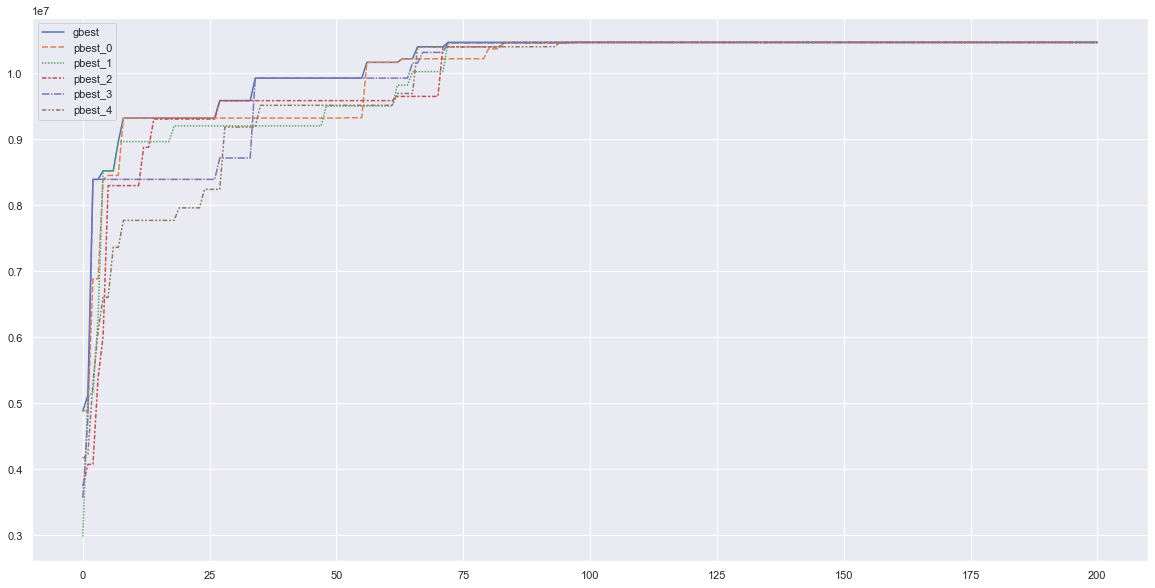

In [41]:
pgbest_col = get_pgbest_col(Nsol)
sns.lineplot(data=df[pgbest_col])
sns.set(rc={'figure.figsize':(30,10)})

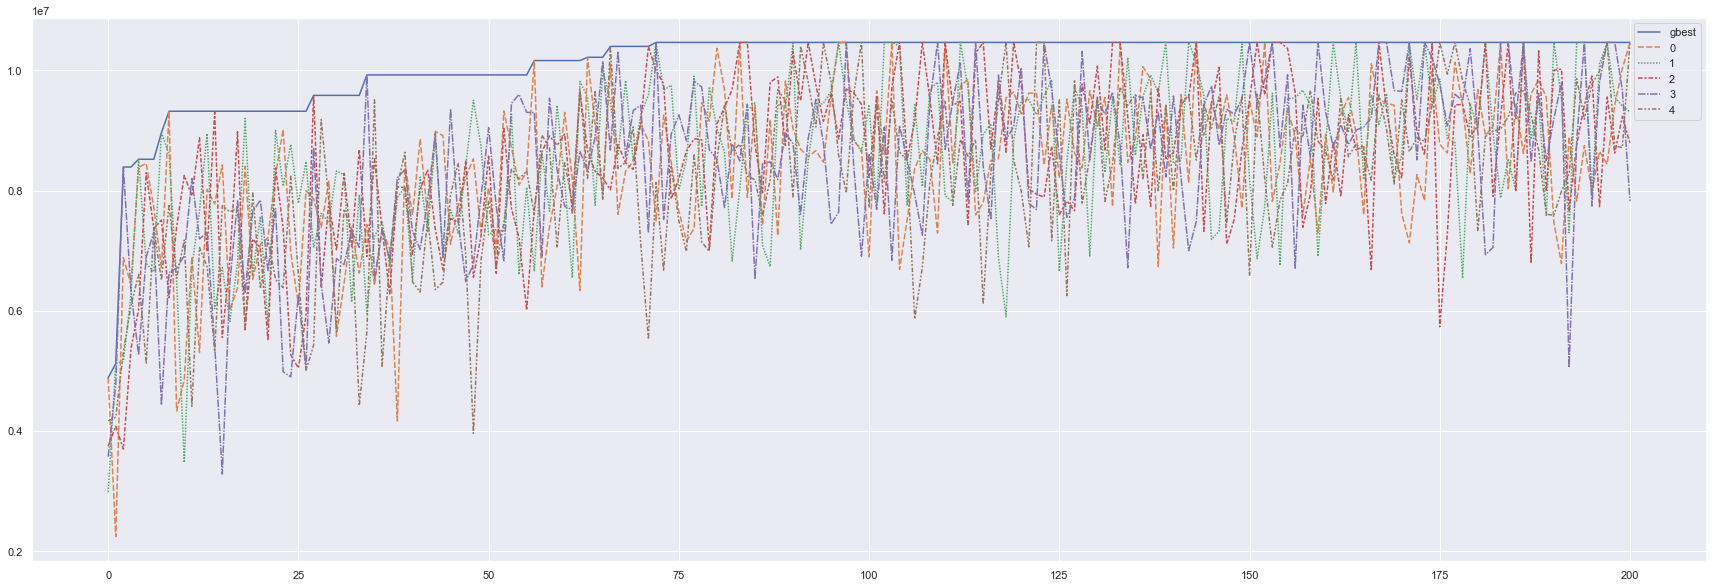

In [28]:
sol_col = get_sol_col(Nsol)
sns.lineplot(data=df[sol_col])
sns.set(rc={'figure.figsize':(30,10)})

# ===============TEST================

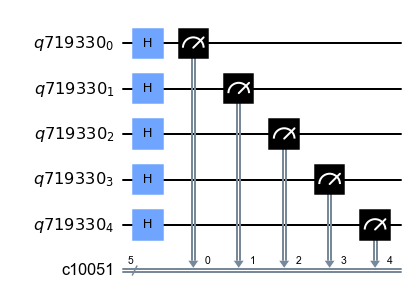

In [29]:
from qiskit import *
%matplotlib inline
# just do this once - save your token to your computer to use later (IBMQ.load_account()
# get the token from your account in https://quantum-computing.ibm.com/
#  MyAccount -> Qiskit in local environment -> Copy Token
# IBMQ.save_account('your token here....’)
### A. Build The Quantum Circuit
qr = QuantumRegister(5) # quantum bit register
cr = ClassicalRegister(5) # classical bit register
circuit = QuantumCircuit(qr, cr)
# create a quantum circuit containing 5 qubits
# all qubits in superposition (50%:50% chance to be in |0> or |1>) and independent of each other
circuit.h(qr)
circuit.measure(qr, cr)
circuit.draw(output='mpl', scale=1)

In [30]:
### B1. Execute the Quantum Circuit in Quantum Computer Simulator
from qiskit.tools.visualization import plot_histogram
# let's execute our Quantum Circuit
backend = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend, shots=8192, memory=True).result()
# get all experiments (number of shots)
rawvalues_sim = result.get_memory()
print(rawvalues_sim)

['10101', '00011', '11000', '10011', '01111', '00110', '00111', '01011', '01001', '11100', '01101', '00111', '01011', '10001', '10101', '00111', '11001', '01001', '01000', '11111', '01001', '01010', '10010', '11010', '10010', '01101', '10011', '11000', '00000', '10000', '11111', '10011', '11010', '01101', '11110', '00000', '01000', '10101', '01010', '10100', '01101', '10101', '00011', '11001', '00111', '11000', '11010', '01101', '00000', '00011', '10001', '00011', '11111', '01110', '01101', '00110', '01000', '01100', '10010', '10100', '00011', '11100', '00110', '01011', '11010', '11100', '11101', '01000', '01011', '11110', '00010', '01100', '00111', '11000', '00111', '11011', '11110', '10101', '00100', '01010', '11001', '01001', '01001', '01010', '01010', '01100', '00001', '10011', '10010', '10001', '11100', '11110', '01101', '00010', '00110', '01101', '01110', '00110', '00111', '10111', '01101', '11000', '10100', '00110', '11110', '10111', '10010', '01010', '11100', '10110', '11111', 

In [31]:
counts = result.get_counts()
print(counts)

{'00000': 249, '00001': 251, '10000': 277, '10001': 250, '10010': 239, '10011': 242, '10100': 236, '10101': 253, '10110': 220, '10111': 233, '11000': 272, '11001': 241, '11010': 280, '11011': 256, '11100': 272, '11101': 234, '11110': 273, '11111': 245, '00010': 264, '00011': 253, '00100': 272, '00101': 255, '00110': 263, '00111': 249, '01000': 258, '01001': 318, '01010': 240, '01011': 277, '01100': 249, '01101': 252, '01110': 252, '01111': 267}


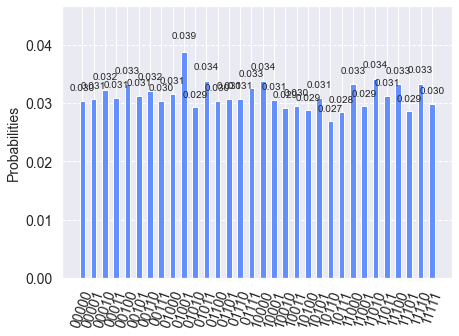

In [32]:
plot_histogram(counts)


In [33]:
### B2. Execute the Quantum Circuit in real Quantum Computer on IBM Quantum Computing Experience
# Run our quantum circuit on The "Quantum Computer on IBM Cloud" by submitting a job containing our defined quantum circuit
from qiskit.tools.monitor import job_monitor
# load saved credential to access IBM Quantum Computing Experience on IBM Cloud
IBMQ.load_account()
# define the backend IBM quantum computer simulator to use
qprovider = IBMQ.get_provider('ibm-q')
qbackend = qprovider.get_backend('ibmq_london’)
job = execute(circuit, backend=qbackend, shots=8192, memory=True)
job_monitor(job)

SyntaxError: EOL while scanning string literal (<ipython-input-33-72d23595eeaa>, line 8)